# Web Scraping a Wiki for Summarization
### By: Eric Tran
#### Introduction
In this project, I will use various Python libraries to webscrape, or acquire the text content of a wikipedia page. I will then use various Python libraries and NLP techniques to clean the data (EDA), perform named entity recognition (NER), part of speech tagging (POS), tokenization to prepare the data, and wordcloud to visualize the top words in the document. I will then use transformers to summarize and perform sentiment analysis.
<br><br>I will then attempt to make a simple chatbot, with the added feature that it will get a sentiment analysis on the user input as well as the chatbot response. It will then create a WordCloud of the top 10 words of the chatbot response, as well as return a summary of the wikipedia article for the main subject of the chatbot response.

First we will need to find a wikipedia page. We already know that Wikipedia pages start with https://en.wikipedia.org/wiki/ and so we will save that to a variable and append a topic. We will start by importing our libraries.

In [35]:
 # processing libraries
import nltk
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download("stopwords")
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from textblob import TextBlob # for sentiment analysis
import numpy as np
import regex # for regular expressions
import requests # for getting HTML code
from bs4 import BeautifulSoup # for parsing the HTML code

# neural network and model libraries
import tensorflow as tf # for tensor use
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# visualization libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from spacy import displacy

### WebScraping
The first thing we are going to do is scrape a wikipedia page. We will use requests to scrape the page for html code, then parse and save the response in a BeautifulSoup object to extract the paragraphs. We will then concantenate the paragraphs to create a long string with all the paragraph texts.

In [15]:
no_wiki_msg = "Sorry, there is no wikipedia page for your subject." # this message will display if there is no wikipedia entry for the input
valid_url = False # this is trigger for whether search string is valid or not
wiki_path = 'https://en.wikipedia.org/wiki/' # general path for wikipedia articles
while not valid_url:
    user_input = str(input('Please Enter a Wikipedia subject: ')) # collects user input
    wiki_url = wiki_path + user_input # create url using input
    response = requests.get(wiki_url) # retrieve url response
    html_content = response.content # retrieve content from response
    soup = BeautifulSoup(html_content, 'html.parser') # create a beautiful soup object with the content
    paragraphs = soup.find_all('p') # find all paragraphs in content
    paragraph_text = [paragraph.get_text() for paragraph in paragraphs] # get text for each paragraph
    all_text = ''
    for text in paragraph_text: # iterates thru all the paragraphs
        all_text = all_text + text # adds each paragraph as text creating giant string
    if all_text == 'Other reasons this message may be displayed:\n': # checks if wiki page is not valid
        print(no_wiki_msg) # if not valid, returns error message and loops starts over
    else:
        print(f'{user_input} is a valid wikipedia subject!') # if valid, prints valid message and set trigger to true, escaping loop
        valid_url = True

Please Enter a Wikipedia subject: gold
gold is a valid wikipedia subject!


In [16]:
print(all_text)


Gold is a chemical element; it has symbol Au (from Latin  aurum 'gold') and atomic number 79. In pure form, it is a bright, slightly orange-yellow, dense, soft, malleable, and ductile metal. Chemically, gold is a transition metal, a group 11 element, and one of the noble metals. It is one of the least reactive chemical elements and is solid under standard conditions.
Gold often occurs in free elemental (native state), as nuggets or grains, in rocks, veins, and alluvial deposits. It occurs in a solid solution series with the native element silver (as in electrum), naturally alloyed with other metals like copper and palladium, and mineral inclusions such as within pyrite. Less commonly, it occurs in minerals as gold compounds, often with tellurium (gold tellurides).
Gold is resistant to most acids, though it does dissolve in aqua regia (a mixture of nitric acid and hydrochloric acid), forming a soluble tetrachloroaurate anion. Gold is insoluble in nitric acid alone, which dissolves silv

### RegEx
Now we have a large string with all the text, but you can see that there are blank new lines, so we will filter those out using the RegEx library, which is similiar to the re library but with more robust features.

In [30]:
text_no_newline = regex.sub('\n', '', all_text)

print(text_no_newline)

Gold is a chemical element; it has symbol Au (from Latin  aurum gold) and atomic number 79. In pure form, it is a bright, slightly orange-yellow, dense, soft, malleable, and ductile metal. Chemically, gold is a transition metal, a group 11 element, and one of the noble metals. It is one of the least reactive chemical elements and is solid under standard conditions.Gold often occurs in free elemental (native state), as nuggets or grains, in rocks, veins, and alluvial deposits. It occurs in a solid solution series with the native element silver (as in electrum), naturally alloyed with other metals like copper and palladium, and mineral inclusions such as within pyrite. Less commonly, it occurs in minerals as gold compounds, often with tellurium (gold tellurides).Gold is resistant to most acids, though it does dissolve in aqua regia (a mixture of nitric acid and hydrochloric acid), forming a soluble tetrachloroaurate anion. Gold is insoluble in nitric acid alone, which dissolves silver an

### Tokenization
Now that the new lines are gone, we are going to do a basic .strip().split('.') to tokenize the long string into sentences using the periods as splitting points.

In [31]:
# tokenize using strip() and split()
sentences = text_no_newline.strip().split('.')

print(sentences)

['Gold is a chemical element; it has symbol Au (from Latin  aurum\xa0gold) and atomic number 79', ' In pure form, it is a bright, slightly orange-yellow, dense, soft, malleable, and ductile metal', ' Chemically, gold is a transition metal, a group 11 element, and one of the noble metals', ' It is one of the least reactive chemical elements and is solid under standard conditions', 'Gold often occurs in free elemental (native state), as nuggets or grains, in rocks, veins, and alluvial deposits', ' It occurs in a solid solution series with the native element silver (as in electrum), naturally alloyed with other metals like copper and palladium, and mineral inclusions such as within pyrite', ' Less commonly, it occurs in minerals as gold compounds, often with tellurium (gold tellurides)', 'Gold is resistant to most acids, though it does dissolve in aqua regia (a mixture of nitric acid and hydrochloric acid), forming a soluble tetrachloroaurate anion', ' Gold is insoluble in nitric acid alo

In [26]:
len(sentences)

465

Please note that this removed the period for whatever reason, so we must put it back when we join.
<br><br>Alternatively, we can also use sent_tokenize to tokenize the text into sentences. However, this gives us less sentences after tokenization. We can visually see that sentences that end in a period but with no space after the period were not properly tokenized.

In [34]:
# tokenize into sentences using sent_tokenize
sent_tokenized = sent_tokenize(text_no_newline)
for i in range(len(sent_tokenized)):
    sent_tokenized[i] = regex.sub('\'','', sent_tokenized[i])
    sent_tokenized[i] = regex.sub('\"','', sent_tokenized[i])
print(len(sent_tokenized))
print(sent_tokenized)

355
['Gold is a chemical element; it has symbol Au (from Latin  aurum\xa0gold) and atomic number 79.', 'In pure form, it is a bright, slightly orange-yellow, dense, soft, malleable, and ductile metal.', 'Chemically, gold is a transition metal, a group 11 element, and one of the noble metals.', 'It is one of the least reactive chemical elements and is solid under standard conditions.Gold often occurs in free elemental (native state), as nuggets or grains, in rocks, veins, and alluvial deposits.', 'It occurs in a solid solution series with the native element silver (as in electrum), naturally alloyed with other metals like copper and palladium, and mineral inclusions such as within pyrite.', 'Less commonly, it occurs in minerals as gold compounds, often with tellurium (gold tellurides).Gold is resistant to most acids, though it does dissolve in aqua regia (a mixture of nitric acid and hydrochloric acid), forming a soluble tetrachloroaurate anion.', 'Gold is insoluble in nitric acid alone

To move forward we will go with using the strip().split() method since it seems some of the sentences did not get split using the sent_tokenize() method.
<br><br>
## EDA (Data cleaning and prep)
Next, we will clean the text some more so we can use in our pretrained models. Of course, we will start by removing stopwords, punctuations, and create a list of all the words after cleaning.

In [36]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\etran\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\etran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
# This function takes in a string and returns tokenized sentences and words
def preprocess_text(text):
    """sentences = sent_tokenize(text) # tokenize into sentences
    stop_words = set(stopwords.words("english")) # removes stop words

    words = [word_tokenize(sentence.lower()) for sentence in sentences] # tokenize into words that are lower case
    words = [[word for word in sentence if word.isalnum() and word not in stop_words] for sentence in words] # removes special characters and stop words
    """
    stop_words = set(stopwords.words("english")) # removes stop words
    text_no_newline = regex.sub('\n', '', all_text)
    sentences = text_no_newline.strip().split('.')
    #words = [word_tokenize(sentence.lower()) for sentence in sentences] # tokenize into words that are lower case
    #words = [[word for word in sentence if word.isalnum() and word not in stop_words] for sentence in words] # removes special characters and stop words
    
    cleaned_words = []
    for idx_sent in range(len(sentences)):
        temp = sentences[idx_sent].lower().split()
        for idx_word in range(len(temp)):
            if temp[idx_word].isalnum and temp[idx_word] not in stop_words:
                cleaned_words.append(temp[idx_word])
    #cleaned_words.append = [word.lower() for word in cleaned_wor
    return sentences, cleaned_words

We will now run the function we just made, passing in our long string. We will get out cleaned sentences and cleaned words.

In [76]:
processed_sentences, processed_words = preprocess_text(all_text)
print(len(processed_sentences))
print(processed_sentences)


465
['Gold is a chemical element; it has symbol Au (from Latin  aurum\xa0gold) and atomic number 79', ' In pure form, it is a bright, slightly orange-yellow, dense, soft, malleable, and ductile metal', ' Chemically, gold is a transition metal, a group 11 element, and one of the noble metals', ' It is one of the least reactive chemical elements and is solid under standard conditions', 'Gold often occurs in free elemental (native state), as nuggets or grains, in rocks, veins, and alluvial deposits', ' It occurs in a solid solution series with the native element silver (as in electrum), naturally alloyed with other metals like copper and palladium, and mineral inclusions such as within pyrite', ' Less commonly, it occurs in minerals as gold compounds, often with tellurium (gold tellurides)', 'Gold is resistant to most acids, though it does dissolve in aqua regia (a mixture of nitric acid and hydrochloric acid), forming a soluble tetrachloroaurate anion', ' Gold is insoluble in nitric acid

In [77]:
print(len(processed_words))
print(processed_words)

5890
['gold', 'chemical', 'element;', 'symbol', 'au', '(from', 'latin', 'aurum', 'gold)', 'atomic', 'number', '79', 'pure', 'form,', 'bright,', 'slightly', 'orange-yellow,', 'dense,', 'soft,', 'malleable,', 'ductile', 'metal', 'chemically,', 'gold', 'transition', 'metal,', 'group', '11', 'element,', 'one', 'noble', 'metals', 'one', 'least', 'reactive', 'chemical', 'elements', 'solid', 'standard', 'conditions', 'gold', 'often', 'occurs', 'free', 'elemental', '(native', 'state),', 'nuggets', 'grains,', 'rocks,', 'veins,', 'alluvial', 'deposits', 'occurs', 'solid', 'solution', 'series', 'native', 'element', 'silver', '(as', 'electrum),', 'naturally', 'alloyed', 'metals', 'like', 'copper', 'palladium,', 'mineral', 'inclusions', 'within', 'pyrite', 'less', 'commonly,', 'occurs', 'minerals', 'gold', 'compounds,', 'often', 'tellurium', '(gold', 'tellurides)', 'gold', 'resistant', 'acids,', 'though', 'dissolve', 'aqua', 'regia', '(a', 'mixture', 'nitric', 'acid', 'hydrochloric', 'acid),', 'for

Now it's time to start getting useful information out of our data using some of the libraries. We will start with nltk to find the parts of speech (POS), then we will use transformers, specifically the pipeline module that contains many pretrained models.

### POS
Parts of speech is very important in NLP. We will use the nltk library to tag each word.

In [107]:
nltk.pos_tag(processed_words) # tags each word with its part of speech tag

[('gold', 'NN'),
 ('chemical', 'NN'),
 ('element;', 'NN'),
 ('symbol', 'NN'),
 ('au', 'NN'),
 ('(from', 'NNP'),
 ('latin', 'NN'),
 ('aurum', 'NN'),
 ('gold)', 'NN'),
 ('atomic', 'JJ'),
 ('number', 'NN'),
 ('79', 'CD'),
 ('pure', 'NN'),
 ('form,', 'NN'),
 ('bright,', 'NN'),
 ('slightly', 'RB'),
 ('orange-yellow,', 'JJ'),
 ('dense,', 'NN'),
 ('soft,', 'NN'),
 ('malleable,', 'NN'),
 ('ductile', 'IN'),
 ('metal', 'NN'),
 ('chemically,', 'NN'),
 ('gold', 'NN'),
 ('transition', 'NN'),
 ('metal,', 'NN'),
 ('group', 'NN'),
 ('11', 'CD'),
 ('element,', 'NN'),
 ('one', 'CD'),
 ('noble', 'JJ'),
 ('metals', 'NNS'),
 ('one', 'CD'),
 ('least', 'JJS'),
 ('reactive', 'JJ'),
 ('chemical', 'JJ'),
 ('elements', 'NNS'),
 ('solid', 'JJ'),
 ('standard', 'JJ'),
 ('conditions', 'NNS'),
 ('gold', 'VBP'),
 ('often', 'RB'),
 ('occurs', 'VBZ'),
 ('free', 'JJ'),
 ('elemental', 'JJ'),
 ('(native', 'JJ'),
 ('state),', 'NN'),
 ('nuggets', 'NNS'),
 ('grains,', 'VBP'),
 ('rocks,', 'JJ'),
 ('veins,', 'JJ'),
 ('alluvial'

### Transformers

In [102]:
import transformers # library with pipline
transformers.logging.set_verbosity_error() # to display errors

from transformers import pipeline # class with many pretrained models for various NLP tasks, from transformers library

The first thing we are going to do with the pipline is make an instance using the NER task setting, which will tag each entity with its NER tag.

In [104]:
nlp = pipeline(task='ner') # this creates instance of pipline class that is trained with NER functionality
for item in nlp(all_text): # iterates thru each word and performs Named Entity Recognition and tagging
    print(f"{item['word'], item['entity']}") # prints NER results of each entity found

('Latin', 'I-MISC')
('Nixon', 'I-PER')
('China', 'I-LOC')
('Russia', 'I-LOC')
('Australia', 'I-LOC')


Of course, we can also do NER using SpaCy and displacy to visualize it, which looks much better.

In [106]:
spacy_nlp = spacy.load('en_core_web_sm')
doc = spacy_nlp(all_text)
displacy.render(doc, style='ent', jupyter=True)

Next, we will make another instance of the pipeline, but this time the task will be set to summarization. With this, we can easily get the summary of the article.

In [108]:
# create a summarization pipeline using a pre-trained model designed for text summarization.
summary_pipe = pipeline(task='summarization')
#sum_len = len(all_text)/20 # this variable is 5% of the number of characters in the document 
sum_len = 500
# uses the nlp function to perform text summarization on the input text stored in the txt variable.
summary = summary_pipe(all_text, max_length=sum_len, min_length=30)
print(summary)

ResourceExhaustedError: Exception encountered when calling layer 'SelfAttention' (type TFT5Attention).

{{function_node __wrapped__Einsum_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[1,8,15278,15278] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Einsum] name: 

Call arguments received by layer 'SelfAttention' (type TFT5Attention):
  • hidden_states=tf.Tensor(shape=(1, 15278, 512), dtype=float32)
  • mask=tf.Tensor(shape=(1, 1, 1, 15278), dtype=float32)
  • key_value_states=None
  • position_bias=None
  • past_key_value=None
  • layer_head_mask=None
  • query_length=None
  • use_cache=False
  • training=False
  • output_attentions=False

### Sentiment Analysis
We can perform sentiment analysis on the summary by again using the pipeline pretrained models. For this we will use 'text_classification' as the task type.

In [ ]:
sa_pipe = pipeline("text-classification") # instantiate a pretrained BERT model for sentiment analysis

In [ ]:
sa_pipe(summary)

Reading the summary, it seems like an efficient way to summarize the content as these sentences seem very relevant and informative.

Next, let's do some visualization. Here is a basic wordcloud using the original text.

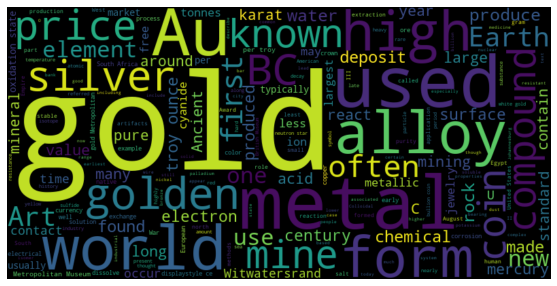

In [109]:
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We will continue with the visualization by using FreqDist, a module in nltk that lets us find the most common words, as well as plot them easily.

In [110]:
from nltk.probability import FreqDist
fdist = FreqDist(processed_words)

In [111]:
fdist.most_common(10)

[('gold', 348),
 ('used', 38),
 ('gold,', 32),
 ('also', 27),
 ('golden', 20),
 ('per', 18),
 ('world', 17),
 ('metal', 16),
 ('often', 16),
 ('high', 16)]

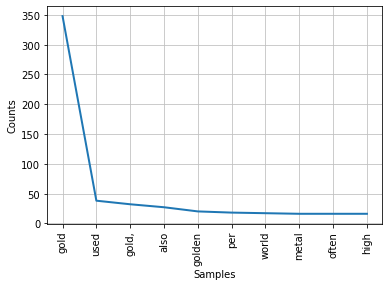

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [112]:
fdist.plot(10) # plots the 10 most common words

# Conclusions
As we can see from this project, there are many tools available to us today to easily perform some of the NLP tasks that once took lots and lots of code. The new tools are more powerful, although they don't always work better as was the case with the sent_tokenize and word_tokenize modules. They also seemed to take more time and processing, as was seen from using pipeline vs spacy for NER. 
<br><br>
Also, my summary did not work on my machine due to memory issues, and the pipeline module could not load on the virtual machines. This is probably due to path and transformers versions. I ran out of time and did not get to the chatbot portion of the project, although I have everything else complete other than the chatbot. I will revisit this at a later date to fix the pipeline/transformers, enter the chatbot, add the necessary modules, and update to my GitHub repository.

In [113]:
# DO NOT RUN DOES NOT WORK

"""import gensim
from gensim.models import Word2Vec
# from gensim.summarization import summarize


model = Word2Vec(processed_words, min_count=1, vector_size=100, window=5, sg=1)
model.build_vocab(processed_words)
model.train(processed_words,total_examples=model.corpus_count,epochs=20)
sentence_vectors = []
for sentence in processed_words:
    if len(sentence) != 0:
        sentence_vec = sum([model.wv[word] for word in sentence]) #/ len(sentence)
        sentence_vectors.append(sentence_vec)

#similarity_matrix = [[model.wv.similarity(w1, w2) for w1 in sentence_vectors] for w2 in sentence_vectors]
#similarity_scores = similarity_matrix.sum(axis=1) # axis = 1 means horizontal
ms = model.wv.most_similar('gold', topn= 6)[1:]
#top_sentences_indices = np.argsort(ms, axis=0)[-5:] # axis = 0 means sort vertically, and get the top 5
#top_sentences = []
for index in range(len(ms)):
    val = processed_sentences[index]
    summary = ''.join(val) + '.'
    #print(summary)

#summary = summarize(" ".join(sentences), ratio=0.3, word_count=None, split=False)

"""



'import gensim\nfrom gensim.models import Word2Vec\n# from gensim.summarization import summarize\n\n\nmodel = Word2Vec(processed_words, min_count=1, vector_size=100, window=5, sg=1)\nmodel.build_vocab(processed_words)\nmodel.train(processed_words,total_examples=model.corpus_count,epochs=20)\nsentence_vectors = []\nfor sentence in processed_words:\n    if len(sentence) != 0:\n        sentence_vec = sum([model.wv[word] for word in sentence]) #/ len(sentence)\n        sentence_vectors.append(sentence_vec)\n\n#similarity_matrix = [[model.wv.similarity(w1, w2) for w1 in sentence_vectors] for w2 in sentence_vectors]\n#similarity_scores = similarity_matrix.sum(axis=1) # axis = 1 means horizontal\nms = model.wv.most_similar(\'gold\', topn= 6)[1:]\n#top_sentences_indices = np.argsort(ms, axis=0)[-5:] # axis = 0 means sort vertically, and get the top 5\n#top_sentences = []\nfor index in range(len(ms)):\n    val = processed_sentences[index]\n    summary = \'\'.join(val) + \'.\'\n    #print(summar

In [114]:
# DO NOT RUN DOES NOT WORK
"""#summary = summarize_text(processed_sentences, processed_words)
token_words = []
for sent in processed_sentences:
    token_words.append(sent)
summary = summarize_text(processed_sentences, token_words)
print(summary)
"""

'#summary = summarize_text(processed_sentences, processed_words)\ntoken_words = []\nfor sent in processed_sentences:\n    token_words.append(sent)\nsummary = summarize_text(processed_sentences, token_words)\nprint(summary)\n'

In [115]:
# ms = model.wv.most_similar(user_input, topn= 6)[1:]